<a href="https://colab.research.google.com/github/GuillaumeMagnette/Stage_Tritons/blob/master/Impl%C3%A9mentation_Triplet_loss_stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Keras implementation of Triplet Loss

In [23]:
!pip install git+https://github.com/tensorflow/docs
!git clone https://github.com/GuillaumeMagnette/Stage_Tritons.git


import urllib

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0o6ggt8y
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-0o6ggt8y
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp36-none-any.whl size=82109 sha256=4eff2cb2c9b78e6c51fe78c3146a3b85888e70cc49ba5bc1645d52188b457adf
  Stored in directory: /tmp/pip-ephem-wheel-cache-rpdb_u9h/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
fatal: destination path 'Stage_Tritons' already exists and is not an empty directory.


In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras import Sequential


from numpy import linalg as LA

In [0]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')
#!cp '/content/drive/My Drive/slim.zip' slim.zip
#!unzip -q /content/drive/"My Drive"/male.zip


In [0]:
import os

#image_list = []
#label_list = []
count_label = 0
base_path = "/content/Stage_Tritons/faces94/male"
#epochs = 50

for class_name in os.listdir(base_path):
      class_path = os.path.join(base_path, class_name)
      #label_map_dict[class_name]=count_label
      count_label += 1
      for image_name in os.listdir(class_path):
        if image_name.endswith("jpg"):
          path = os.path.join(class_path, image_name)
          target = os.path.join(class_path,str(image_name[:-3]+'jpeg'))
          os.rename(path, target)
        
          #os.rename(image_name, str(image_name[:-3]+'jepg'))
          #image_path = os.path.join(class_path, image_name)

         # label_list.append(count_label)
         # image_list.append(image_path)

          
 
#dataset = tf.data.Dataset.from_tensor_slices((tf.constant(image_list), tf.constant(label_list)))
#dataset = dataset.shuffle(len(image_list))
#dataset = dataset.repeat(epochs)
#dataset = dataset.map(_parse_function).batch(batch_size)

In [0]:
import pathlib

width = 56
height = 56


def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [width, height])

def process_path(file_path):
  print(file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  try:
    img = decode_img(img)
    print("decoded")
    counter +=1
  except:
    print("erreur décodage")

  return img, label

In [0]:
import os
import pathlib


#epochs = 50
nbr_element = 0

base_path = pathlib.Path(base_path)

list_ds = tf.data.Dataset.list_files(str(base_path)+'/*/*')

for class_name in os.listdir(base_path):
      class_path = os.path.join(base_path, class_name)
      #label_map_dict[class_name]=count_label

      for image_name in os.listdir(class_path):
        file_path = os.path.join(class_path, image_name)
        img = tf.io.read_file(file_path)
        try:
          img = decode_img(img)
          #print("decoded")
          nbr_element += 1

        except:
          #print("erreur décodage")
          os.remove(file_path)

  
        
          #os.rename(image_name, str(image_name[:-3]+'jepg'))
          #image_path = os.path.join(class_path, image_name)

         # label_list.append(count_label)
         # image_list.append(image_path)

        

In [31]:

#BATCH_SIZE = 32

#data_dir = "/content/male"

data_dir = pathlib.Path(base_path)

list_ds = tf.data.Dataset.list_files(str(data_dir)+'/*/*')
#list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

for f in list_ds.take(5):
  print(f.numpy())
counter = 0

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

def augment(image,label):
  #image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  #image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  #image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.image.flip_left_right(image)

  return image,label
#Use Dataset.map to create a dataset of image, label pairs:

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#train_size = int(0.7 * nbr_element)
train_size=nbr_element
#val_size = int(0.30 * nbr_element)
#test_size = int(0.15 * DATASET_SIZE)


#full_dataset = labeled_ds.shuffle()
train_dataset = labeled_ds.take(train_size)
#test_dataset = labeled_ds.skip(train_size)
#val_dataset = test_dataset.skip(test_size)
#test_dataset = test_dataset.take(val_size)
train_dataset = train_dataset.map(augment, num_parallel_calls=AUTOTUNE)


x_train = np.zeros((train_size,width,height,3))
y_train = np.zeros((train_size))
#x_test = np.zeros((val_size,width,height,3))
#y_test = np.zeros((val_size))

k=0
for image, label in train_dataset:
  x_train[k,:,:,:] = image
  y_train[k] = np.where(label)[0][0]
  k += 1
#k=0
#for image, label in test_dataset:
 # x_test[k,:,:,:] = image
 # y_test[k] = np.where(label)[0][0]
  #k += 1
  #print(np.where(label)[0])
  
  #print("Image shape: ", image.numpy().shape)
  #print("Label: ", label.numpy())
print(y_train)
dataset = []
dataset_test = []
    
#Sorting images by classes and normalize values 0=>
for n in range(count_label):
    images_class_n = np.asarray([row for idx,row in enumerate(x_train) if y_train[idx]==n])
    #print(images_class_n.shape)
    dataset.append(images_class_n/255)
print(len(dataset))
#for n in range(int(count_label*0.30)):
 #   images_class_n = np.asarray([row for idx,row in enumerate(x_test) if y_test[idx]==n])
    #print(images_class_n.shape)
  #  dataset_test.append(images_class_n/255)
        
    #images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
    #dataset_test.append(images_class_n/255)
input_shape = [width,height,3]




b'/content/Stage_Tritons/faces94/male/mberdo/mberdo.2.jpeg'
b'/content/Stage_Tritons/faces94/male/rlocke/rlocke.1.jpeg'
b'/content/Stage_Tritons/faces94/male/rarobi/rarobi.4.jpeg'
b'/content/Stage_Tritons/faces94/male/mdpove/mdpove.19.jpeg'
b'/content/Stage_Tritons/faces94/male/dioann/dioann.12.jpeg'
Tensor("args_0:0", shape=(), dtype=string)
decoded
erreur décodage
[ 18.  25.   8. ...  29. 104.  60.]
113


Ne pas utiliser

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

Méthode créée pour MNIST, ne pas executer dans le cas de la reconnaissance faciale

In [6]:
nb_classes = 10
count_label = nb_classes
img_rows, img_cols = 28, 28
input_shape = [img_rows, img_cols, 1]

def buildDataSet():
    """Build dataset for train and test
    
    
    returns:
        dataset : list of lengh 10 containing images for each classes of shape (?,28,28,1)
    """

    #fashion_mnist = tf.keras.datasets.fashion_mnist

    #(x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = fashion_mnist.load_data()
    (x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = datasets.mnist.load_data()

    assert backend.image_data_format() == 'channels_last'
    x_train_origin = x_train_origin.reshape(x_train_origin.shape[0], img_rows, img_cols, 1)
    x_test_origin = x_test_origin.reshape(x_test_origin.shape[0], img_rows, img_cols, 1)
    
    dataset_train = []
    dataset_test = []
    
    #Sorting images by classes and normalize values 0=>1
    for n in range(nb_classes):
        images_class_n = np.asarray([row for idx,row in enumerate(x_train_origin) if y_train_origin[idx]==n])
        #print(images_class_n.shape)
        dataset_train.append(images_class_n/255)
        
        images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
        dataset_test.append(images_class_n/255)
    
    return dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin

dataset,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin = buildDataSet()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Input, Model

def build_network_feedforward(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Flatten(input_shape=input_shape))
    #network.add(Dense(4096, activation='relu',
     #              kernel_regularizer=l2(1e-3),
      #             kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    #network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    
    return network



Ce réseau de neurones est le meilleur, ne pas executer les autres

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Input, Model

def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (7,7), activation='relu',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Dropout(0.3))
    network.add(BatchNormalization())
    network.add(Conv2D(128, (5,5), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Dropout(0.3))
    network.add(BatchNormalization())
    network.add(Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    #network.add(Dropout(0.5))
    
    network.add(Flatten())
    #network.add(Dense(4096, activation='relu',
     #              kernel_regularizer=l2(1e-3),
      #             kernel_initializer='he_uniform'))
    network.add(BatchNormalization())
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    #network.add(Lambda(lambda x: l2_normalize(x,axis=-1)))
    
    return network



In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Input, Model

def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (5,5),
                     input_shape=input_shape,
                     kernel_initializer='he_uniform'))
    network.add(tf.keras.layers.LeakyReLU(alpha=0.3))
                     ##kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Dropout(0.5))
    
    network.add(Flatten())
    network.add(Dense(2048,
                   kernel_regularizer=l2(1e-5),
                   kernel_initializer='glorot_uniform'))
    network.add(BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    network.add(Dense(512,
                   kernel_regularizer=l2(1e-5),
                   kernel_initializer='glorot_uniform'))
    network.add(BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-5),
                   kernel_initializer='glorot_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: l2_normalize(x,axis=-1)))
    
    return network


In [0]:
def compute_dist(a,b):
    return np.sum(np.square(a-b))
count_label = len(dataset)
def get_batch_moderate_random(batch_size,dataset, s="train"):
    """
    Create batch of APN triplets with a complete random strategy
    
    Arguments:
    batch_size -- integer 
    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (batch_size,w,h,c), (batch_size,w,h,c,k), (batch_size,w,h,c,k,p)
    """
    
    
    m, w, h, c = dataset[0].shape
   # print(m)
    P = int(batch_size*3/4)
    K = 4

    k = 0
    # initialize result
    anchors =np.zeros((P*K, h, w, c))
    positives = np.zeros((P*K, h, w, c, K))
    negatives = np.zeros((P*K, h, w, c, K, P))
    #negatives = np.zeros((P*K, P, K, h, w, c))
    #print("PK =  " + str(P*K))
    
    #Pick one random class for anchor
    #print("nombre de classes : " + str(count_label))
    anchor_class = np.random.choice(count_label, size=P, replace=False)
    #print("longueur anchoir_class : "+str(len(anchor_class)))
    for i in range(len(anchor_class)):

      anchor = anchor_class[i]
     # print(anchor)
      nb_sample_available_for_class_A = dataset[anchor].shape[0]
      
      #Pick K different random pics for this class => A and P
      idxAP = np.random.choice(nb_sample_available_for_class_A,size=K+1,replace=False)
      #print("longueur idxAp : "+str(len(idxAP)))


      negative_class = [id for id in anchor_class if id != anchor]

      for j in range(K):
        idA = idxAP[j]
        idPx = [id for id in idxAP if id != idA]
        #print(i*K+j)
        #print("valeur de i : " + str(i))
        #print("valeur de j : " + str(j))
        #print("longueur idPx " + str(len(idPx)))
        anchors[i*K+j,:,:,:] = dataset[anchor][idA,:,:,:]
        
        for k in range(len(idPx)):
          idP = idPx[k]
          #print(idP)
          positives[i*K+j,:,:,:,k] = dataset[anchor][idP,:,:,:]

        for l in range(len(negative_class)):
            negative = negative_class[l]
            nb_sample_available_for_class_N = dataset[negative].shape[0]
            idxN = np.random.choice(nb_sample_available_for_class_N,size=K,replace=False)

            for k in range(len(idxN)):
              idN = idxN[k]
              negatives[i*K+j,:,:,:,k,l] = dataset[negative][idN,:,:,:]
          
         # if(k>0):
         #   print(positives[i*K+j,:,:,:,k]-positives[i*K+j,:,:,:,k-1])
        
        

        #Pick K different random pics for this class => N
          

        #print("i : " + str(i))
        #print("l : " + str(l))
        #print(i*K+l)

        #
        
          
            #if(k>0):
             # print(tf.subtract(negatives[i*K+l,:,:,:,k,j],negatives[i*K+l,:,:,:,k-1,j]))
        
        #Pick a random pic for this negative class => N
    #print("affichage positives batch random moderate")
    #plt.figure()
    #plt.imshow(positives[0,:,:,0,3])
    return [anchors,positives,negatives]

tripletbatch = get_batch_moderate_random(batch_size=8, dataset = dataset)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:172: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


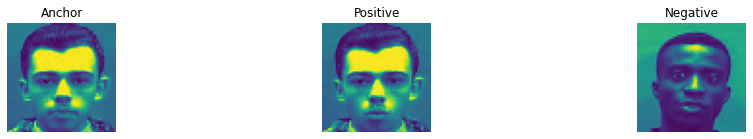

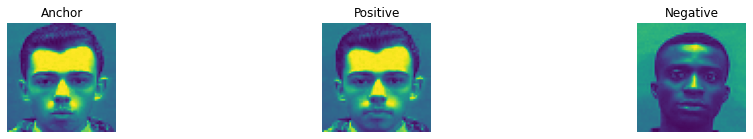

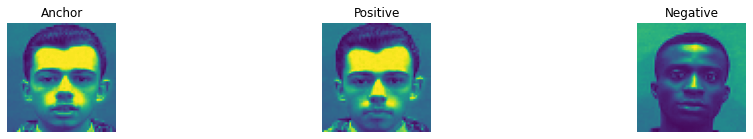

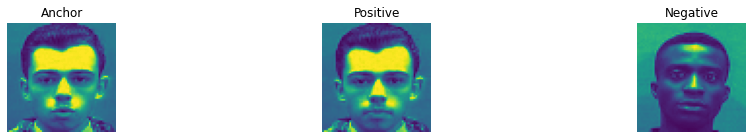

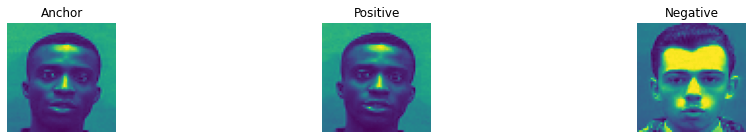

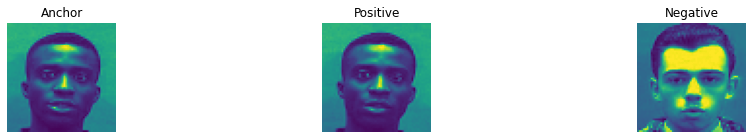

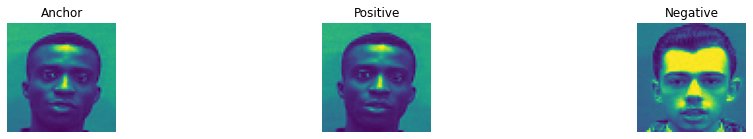

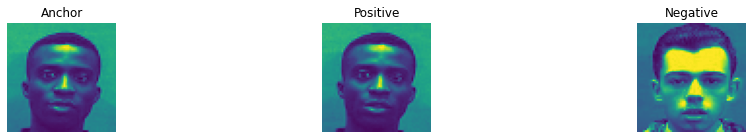

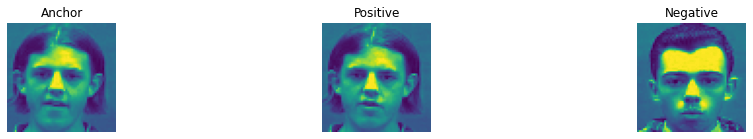

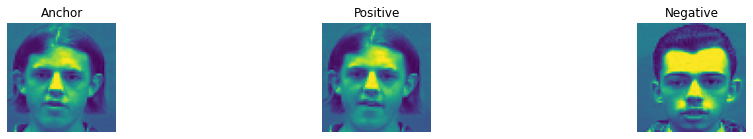

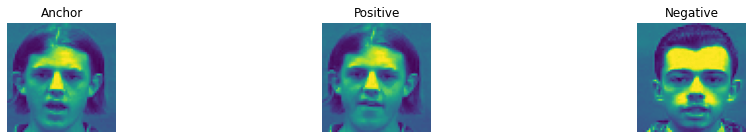

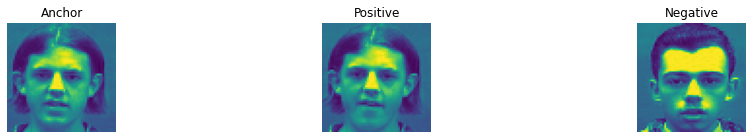

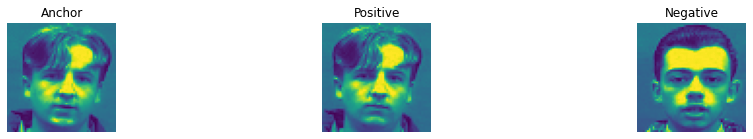

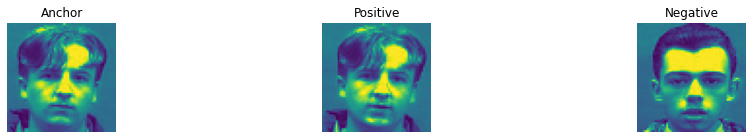

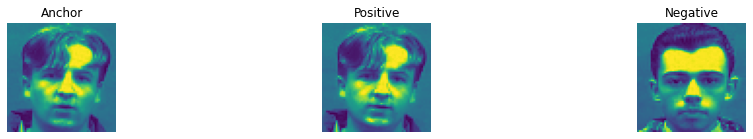

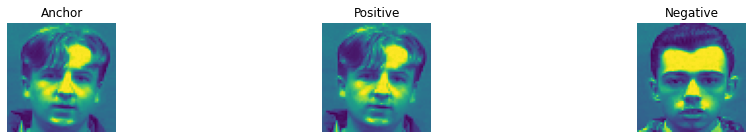

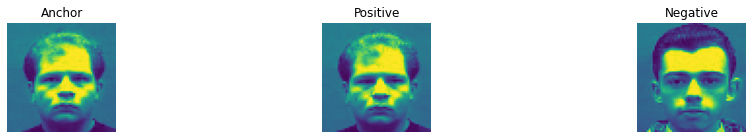

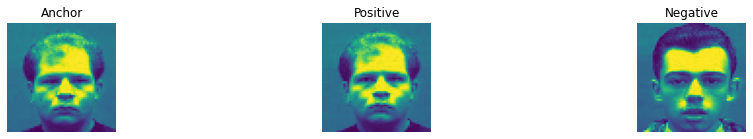

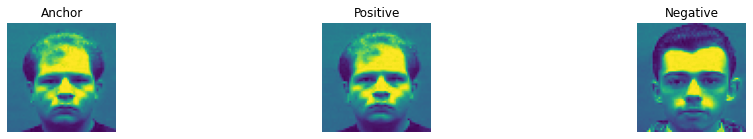

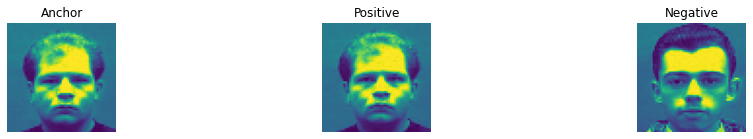

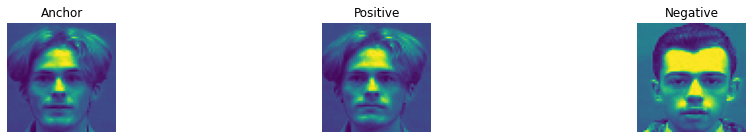

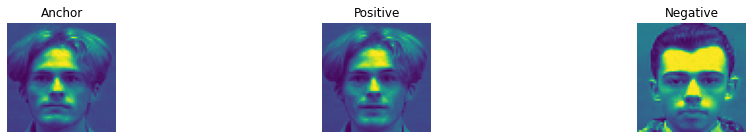

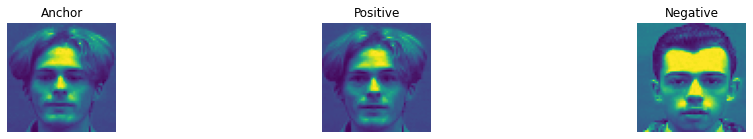

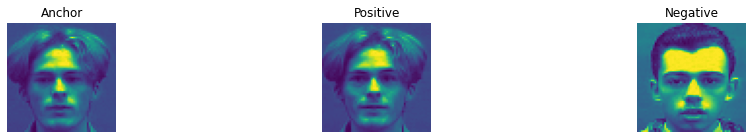

In [35]:


model = build_network(input_shape,128)

def get_batch_moderate(batch_size,network,dataset,s="train"):
    """
    Create batch of APN "moderate" triplets
    
    Arguments:
    draw_batch_size -- integer : number of initial randomly taken samples   
    hard_batchs_size -- interger : select the number of hardest samples to keep
    norm_batchs_size -- interger : number of random samples to add
    Returns:
    
    triplets -- list containing 3 tensors A,P,N of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    """
    if s == 'train':
        X = dataset
    else:
        X = dataset

    m, w, h,c = X[0].shape
    
    
    #Step 1 : pick a random batch to study
    studybatch = get_batch_moderate_random(batch_size,dataset,s)
    
    
    #Compute embeddings for anchors, positive and negatives
    A = network.predict(studybatch[0])
    #print(A.shape)
    P = np.zeros((A.shape[0], A.shape[1], studybatch[1].shape[4]))
    N = np.zeros((A.shape[0], A.shape[1], studybatch[1].shape[4], studybatch[2].shape[5]))  


    for i in range(studybatch[1].shape[4]):
      P[:,:,i] = network.predict(studybatch[1][:,:,:,:,i])
     # plt.figure()
     # plt.imshow(np.squeeze(studybatch[1][0,:,:,:,i]))
      #print(studybatch[1][:,:,:,:,i])
      #if(i>0):
       # print("Pi - Pi-1")
        #print(P[:,:,i] - P[:,:,i-1])
      for j in range(studybatch[2].shape[5]):
        N[:,:,i,j] = network.predict(studybatch[2][:,:,:,:,i,j])
        #if(i>0):
         # print("Ni,j - Ni-1,j")
          #print(N[:,:,i,j] - N[:,:,i-1,j])

    
    ### Extraction des indices des distances maximales
    
    A = tf.expand_dims(A, axis = -1)
    #print(A)
    #print(P)
    dist_p = tf.math.subtract(A,P)
    #print(dist_p)
    dist_p = tf.norm(tf.math.subtract(A,P),axis = -2)
    #print(dist_p)
    selectionAP = tf.math.argmax(tf.norm(A - P,axis = -2), axis = -1)
    #print(selectionAP)
   # print(selectionAP.shape)
    #dist_p = tf.dtypes.cast(dist_p, tf.double)

    
    sub = np.zeros((A.shape[0], A.shape[1], studybatch[1].shape[4], studybatch[2].shape[5]))    
    for i in range(N.shape[3]):
      #print(A.shape)
      #print(tf.math.subtract(N[:,:,i+1,i],N[:,:,i,i]))
      sub[:,:,:,i] = tf.math.subtract(A,N[:,:,:,i])
      #print(sub[:,:,:,i])
    #A = tf.expand_dims(A, axis = -1)
    #print(sub)
    n_dist = tf.norm(sub,axis = 1)
    #print(n_dist)
    n_dist = tf.reduce_min(n_dist, axis = -2)
    #print("n_dist")
    #print(n_dist)
    selectionN = np.argmin(n_dist, axis = -1)
    #print("selectionN")
    #print(selectionN)
   # print(selectionN.shape)
    AN = tf.norm(sub,axis = -3)
    #print("AN")
    #print(AN)

    selectionPN = np.zeros((AN.shape[0]),dtype=np.int8)
    for i in range(AN.shape[0]):
      #print(AN[i,:,selectionN[i]])
      selectionPN[i] = np.argmin(AN[i,:,selectionN[i]])
      
      #print(selectionPN[i])
   # print("selectionPN")
    #print(selectionPN)
    #n_dist = tf.dtypes.cast(n_dist, tf.double)
    batch_size = studybatch[2][:,0,0,0,0,0].shape[0]
   # print(batch_size)
    width = studybatch[2][0,:,0,0,0,0].shape[0]
   # print(width)
    height = studybatch[2][0,0,:,0,0,0].shape[0]
   # print(height)
    channels = studybatch[2][0,0,0,:,0,0].shape[0]
   # print(channels)
    K = studybatch[2][0,0,0,0,:,0].shape[0]
   # print(K)
    N = studybatch[2][0,0,0,0,0,:].shape[0]
   # print(N)

    ### Création des tenseurs contenant les images sélectionnées de telles sortes à maximiser les distances AP et à minimiser les distances AN
    positives = tf.zeros((batch_size,width,height,channels))
    negatives = tf.zeros((batch_size,width,height,channels))

    #print(selectionPN)
    #print(selectionN)
    
    #print(P.shape)
    #print(N.shape)

    
    for i in range(studybatch[2][:,0,0,0,0,0].shape[0]):
      positives = studybatch[1][:,:,:,:,selectionAP[i]]
      #positives = np.squeeze(positives)
      #print(positives)
      #print(positives.shape)
      negatives = studybatch[2][:,:,:,:,selectionPN[i],selectionN[i]]
      #negatives = np.squeeze(negatives)
      #print(negatives.shape)

    #print(positives[0,:,:,0])
    #print(negatives[0,:,:,0])
    #print(positives[0,:,:,:])
    #print(negatives[0,:,:,:])
    #plt.figure()
    #plt.imshow(positives[0,:,:,0])
    #plt.figure()
    #plt.imshow(negatives[0,:,:,0])

    #studybatchloss = tf.math.reduce_sum(tf.math.log1p(tf.math.subtract(p_dist,n_dist)))
    #studybatchloss = tf.dtypes.cast(studybatchloss, tf.float32)

    triplets = [studybatch[0][:,:,:,:], positives, negatives]

    #print(NMin.shape)

    #Compute d(A,P)-d(A,N)
    #studybatchloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    #Sort by distance (high distance first) and take the inverse
    #selection = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    #selection2 = np.random.choice(np.delete(np.arange(draw_batch_size),selection),norm_batchs_size,replace=False)
    
    #selection = np.append(selection,selection2)
    
    #triplets = [A,P,N]
    #print(triplets.shape)
    return triplets

tripletbatch = get_batch_moderate(8, model, dataset)
def drawTriplets(tripletbatch, nbmax=None):
    """display the three images for each triplets in the batch
    """
    labels = ["Anchor", "Positive", "Negative"]

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            plt.axis("off")
            plt.imshow(tripletbatch[i][row,:,:,0])
            subplot.title.set_text(labels[i])

drawTriplets(tripletbatch=tripletbatch)



In [0]:

class TripletLossLayerModerate(layers.Layer):
    def __init__(self, **kwargs):
        #self.alpha = alpha
        super(TripletLossLayerModerate, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        A, P, N = inputs
        
        p_dist = tf.norm(A - P,axis = -1)
        n_dist = tf.norm(A - N,axis = -1)
        
        #tripletLoss = tf.math.reduce_sum(tf.math.add(self.alpha,tf.math.subtract(p_dist,n_dist)))

        #Utilisation de la formule de batch_hard du papier avec marge douce
        tripletLoss = tf.math.reduce_sum(tf.math.log1p(tf.math.exp(tf.math.subtract(p_dist,n_dist))))
        tripletLoss = tf.dtypes.cast(tripletLoss, tf.float32)
        #tripletLoss = backend.sum(backend.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
        return(tripletLoss)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

Construction du modèle du papier

In [0]:
def build_model_moderate(input_shape, network, margin = 0.2):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
    
    
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    #loss_layer = TripletLossLayerModerate(alpha = margin, name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    loss_layer = TripletLossLayerModerate(name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train



In [0]:

import sklearn
from sklearn.metrics import roc_auc_score, roc_curve
def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    distances = np.zeros(())
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes

                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                   # print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                   # print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

In [0]:
def mean_average_precision(X,Y,network,rank):
    '''
    Returns
        MAP : the mean of the average precision of the model for each images of the dataset
    '''
    nb_classes = count_label
    m = X.shape[0]
    nbtrain = 1000
    nbevaluation = 50
    probs = np.zeros((nbevaluation))
    distances = np.zeros((nbevaluation,nb_classes))
    ypreds = np.zeros((nbevaluation,nb_classes))
    y = np.zeros((nbevaluation))

    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]

    ref_images = np.zeros((nb_classes,size_embedding))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
          #print(dataset_train[i][:,0,0,1])
          #idx_ref = np.random.choice(dataset_train[i][:,0,0,1],size=200,replace=False)
          #print(idx_ref)
          #print(len(dataset_train[i][0]))
          #print(np.take(dataset_train[, idx_ref))
          selected_ref = dataset[i][:nbtrain,:,:,:]
          #print(selected_ref.shape)
          ref_images[i,:] = np.mean(network.predict(selected_ref),axis=0)
          #print(ref_images[i,:].shape)
    #print(np.mean(network.predict(selected_ref),axis=0).shape)
    
    test = compute_dist(ref_images[0,:],network.predict(np.expand_dims(dataset[15][0,:,:,:], axis=0)))
    print(test)
    for j in range(nbevaluation):
          print(j)
          for k in range(nb_classes):
              #print(X[j,:,:,:].shape)
              distances[j,k] = compute_dist(ref_images[k,:],network.predict(np.expand_dims(X[j,:,:,:]/255, axis=0)))
              #print(distances[j,k])
          #print(distances[j,:])
    #for i in range(nb_classes):
     #for k in range(nb_classes):
      #for j in range(nbevaluation):
              #print(X[j,:,:,:].shape)
       #       distances[j,k] = compute_dist(ref_images[i,:],network.predict(np.expand_dims(dataset[k][j,:,:,:], axis=0)))
        #      print(distances[j,k])
          #print(distances[j,:])
    #print("affichage des distances triées selon l'axe des classes")
    ypreds = np.argsort(distances,axis=-1)
    #print(ypreds[0])
    #print("affichage des distances triées selon l'axe des classes")
    #ypreds = np.flip(ypreds,axis = -1)
    #print(ypreds[0])
    ytrue = Y[:nbevaluation]
    #print(ytrue)

    AP = 0
    #print(len(ytrue))
    
    for i in range(len(ytrue)):
      #print(ypreds[i,:rank])
      #print(ytrue[i])
      print(ytrue)
      print(ypreds[i,0])
      for k in range(rank):
        
        if(ytrue[i] == ypreds[i,k]):
          AP += 1/(k+1)
    
    MAP = AP/len(ytrue)
    print(MAP)
    return MAP


def cumulative_matching_curve(X,Y,network,rank):
  
    '''
    Returns
        CMC : 
    '''
    nb_classes = count_label
    m = X.shape[0]
    nbtrain = 1000
    nbevaluation = 50
    probs = np.zeros((nbevaluation))
    distances = np.zeros((nbevaluation,nb_classes))
    ypreds = np.zeros((nbevaluation,nb_classes))
    y = np.zeros((nbevaluation))

    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]

    ref_images = np.zeros((nb_classes,size_embedding))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
          #print(dataset_train[i][:,0,0,1])
          #idx_ref = np.random.choice(dataset_train[i][:,0,0,1],size=200,replace=False)
          #print(idx_ref)
          #print(len(dataset_train[i][0]))
          #print(np.take(dataset_train[, idx_ref))
          selected_ref = dataset[i][:nbtrain,:,:,:]
          #print(selected_ref.shape)
          ref_images[i,:] = np.mean(network.predict(selected_ref),axis=0)
          #print(ref_images[i,:].shape)
    #print(np.mean(network.predict(selected_ref),axis=0).shape)
    
    test = compute_dist(ref_images[0,:],network.predict(np.expand_dims(dataset[15][0,:,:,:], axis=0)))
    print(test)
    for j in range(nbevaluation):
          print(j)
          for k in range(nb_classes):
              #print(X[j,:,:,:].shape)
              distances[j,k] = compute_dist(ref_images[k,:],network.predict(np.expand_dims(X[j,:,:,:]/255, axis=0)))
              #print(distances[j,k])
          #print(distances[j,:])
    #for i in range(nb_classes):
     #for k in range(nb_classes):
      #for j in range(nbevaluation):
              #print(X[j,:,:,:].shape)
       #       distances[j,k] = compute_dist(ref_images[i,:],network.predict(np.expand_dims(dataset[k][j,:,:,:], axis=0)))
        #      print(distances[j,k])
          #print(distances[j,:])
    #print("affichage des distances triées selon l'axe des classes")
    ypreds = np.argsort(distances,axis=-1)
    #print(ypreds[0])
    #print("affichage des distances triées selon l'axe des classes")
    #ypreds = np.flip(ypreds,axis = -1)
    #print(ypreds[0])
    ytrue = Y[:nbevaluation]
    #print(ytrue)

    present = 0
    #print(len(ytrue))
    
    for i in range(len(ytrue)):
      #print(ypreds[i,:rank])
      #print(ytrue[i])
      for k in range(rank):
        #print(ytrue)
        #print(ypreds[i,k])
        if(ytrue[i] == ypreds[i,k]):
          present += 1
    
    CMC = present/len(ytrue)
    print(CMC)
    return CMC

    




def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    nb_classes = count_label
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes,28,28,3))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

In [0]:
import time
embedding_size = 256
tf.keras.backend.clear_session()
model = build_network(input_shape,embedding_size)
model_trained = build_model_moderate(input_shape, model)

model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

#inter_dist = compute_interdist(model)
#print(inter_dist)

In [40]:


#model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1 = 0.5, amsgrad=False))

n_iter = 3000
n_iteration = 0
evaluate_every = 10
n_val = 1000
print("Starting training process!")
print("-------------------------------------")

distribution = np.zeros((10,3))
t_start = time.time()
plt.figure()
for i in range(1, n_iter+1):
    triplets = get_batch_moderate(20,model,dataset)
    
    #print(triplets.shape)
    loss = model_trained.train_on_batch(triplets, None)
    n_iteration += 1
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,np.nan_to_num(loss),n_iteration))

       # inter_dist = compute_interdist(model)
       # print(inter_dist)

        #MAP = mean_average_precision(x_train,y_train,model,1)
        #CMC = cumulative_matching_curve(x_test_origin,y_test_origin,model,5)
        #print("Mean Average Precision" + str(MAP))
        #print("Cumulative Matching Curve = " + str(CMC))
        #probs,yprob = compute_probs(model,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
        #model.predict(x_test_origin[:n_val,:,:,:])
        #plt.plot(fpr,tpr)
       # res = compute_interdist(model)
       # print(res)

Starting training process!
-------------------------------------

 ------------- 

[10] Time for 10 iterations: 0.2 mins, Train Loss: 36.761383056640625

 ------------- 

[20] Time for 20 iterations: 0.3 mins, Train Loss: 7.1980061531066895

 ------------- 

[30] Time for 30 iterations: 0.5 mins, Train Loss: 18.489988327026367

 ------------- 

[40] Time for 40 iterations: 0.6 mins, Train Loss: 7.621140956878662

 ------------- 

[50] Time for 50 iterations: 0.8 mins, Train Loss: 2.1725120544433594

 ------------- 

[60] Time for 60 iterations: 1.0 mins, Train Loss: 0.8243710994720459


KeyboardInterrupt: ignored

<Figure size 864x360 with 0 Axes>

In [0]:
import io
import tensorflow_datasets as tfds

results = model.predict(x_train)
# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for labels in y_train:
    out_m.write(str(labels) + "\n")
out_m.close()


try:
  from google.colab import files
  files.download('vecs.tsv')
  files.download('meta.tsv')
except:
  pass

In [41]:
#print(dataset_train)
MAP = mean_average_precision(x_train,y_train,model,1)

0.16302731183995617
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
[ 18.  25.   8.  39.  25.  15.  21.  55.  42.   3.  95.  70.  55.   4.
  14.  84.   8.   0.  27.  84.   4.  39.  22.  94.  41. 104.  38.  91.
  36.  38.   6.  55.   6.   6.  90.  33.  93.  24.  14. 111.  21. 112.
  94.  85.  97.  14.  38.   3.  96.  55.]
18
[ 18.  25.   8.  39.  25.  15.  21.  55.  42.   3.  95.  70.  55.   4.
  14.  84.   8.   0.  27.  84.   4.  39.  22.  94.  41. 104.  38.  91.
  36.  38.   6.  55.   6.   6.  90.  33.  93.  24.  14. 111.  21. 112.
  94.  85.  97.  14.  38.   3.  96.  55.]
25
[ 18.  25.   8.  39.  25.  15.  21.  55.  42.   3.  95.  70.  55.   4.
  14.  84.   8.   0.  27.  84.   4.  39.  22.  94.  41. 104.  38.  91.
  36.  38.   6.  55.   6.   6.  90.  33.  93.  24.  14. 111.  21. 112.
  94.  85.  97.  14.  38.   3.  96.  55.]
8
[ 18.  25.   8.  39.  25.  15.  21.  55.  42.   3.  95.  70.  55.  

In [0]:
from sklearn.decomposition import PCA

model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, amsgrad=False))

n_iteration = 0
t_start = time.time()
plt.figure()
for i in range(1, 10+1):
    triplets = get_batch_moderate(14,model)
    #print(triplets.shape)
    loss = model_trained.train_on_batch(triplets, None)
    n_iteration += 1
    
print("\n ------------- \n")
print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(10, (time.time()-t_start)/60.0,np.nan_to_num(loss),n_iteration))

pca = PCA(n_components=2)
pca.fit(model.predict(x_test_origin[:n_val,:,:,:]))
print(pca)
plt.imshow(pca)
        #probs,yprob = compute_probs(model,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
        #model.predict(x_test_origin[:n_val,:,:,:])
        #plt.plot(fpr,tpr)
       # res = compute_interdist(model)
       # print(res)


 ------------- 

[10] Time for 10 iterations: 0.2 mins, Train Loss: 13.344663619995117


AttributeError: ignored

<Figure size 432x288 with 0 Axes>

In [0]:
pca = PCA(n_components=2)
Xproj = pca.fit_transform(model.predict(x_test_origin[:n_val,:,:,:]))
print(Xproj)
plt.scatter(Xproj)

NameError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:170: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


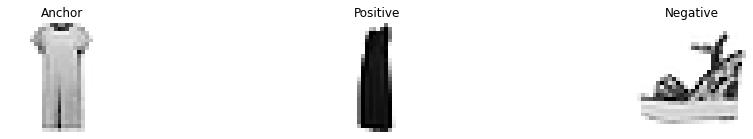

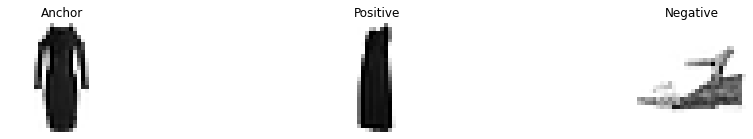

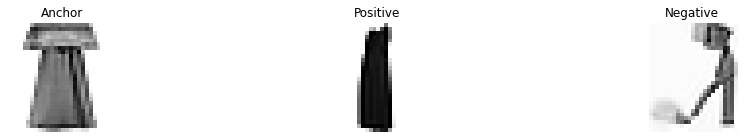

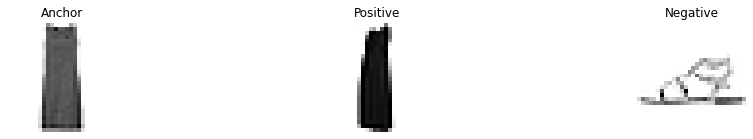

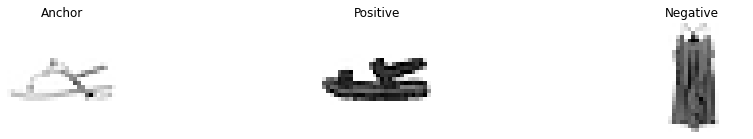

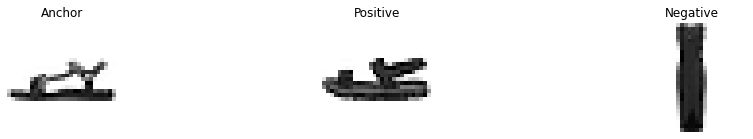

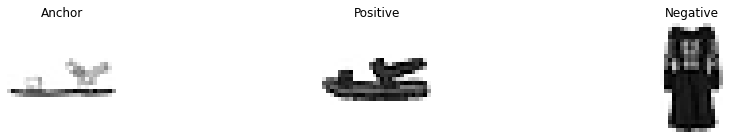

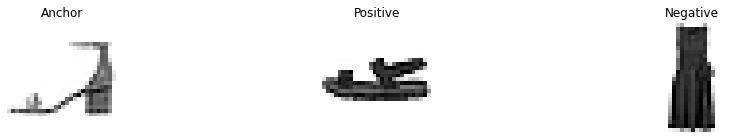

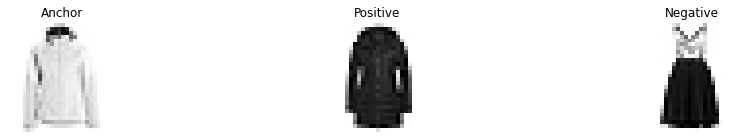

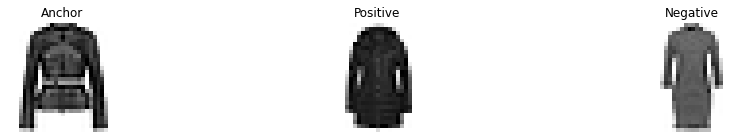

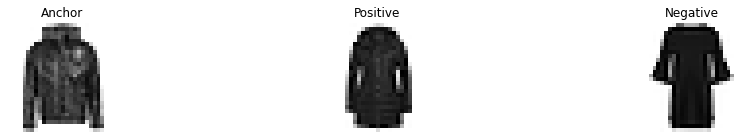

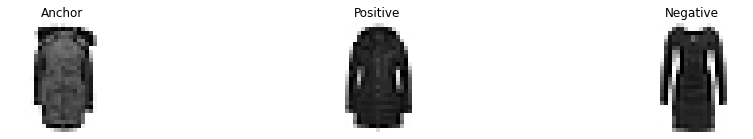

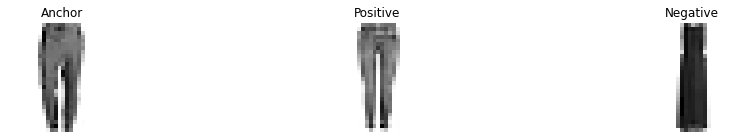

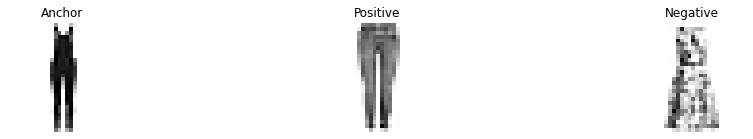

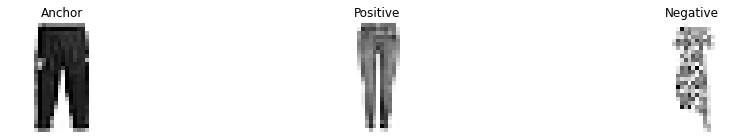

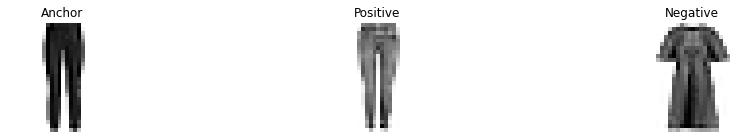

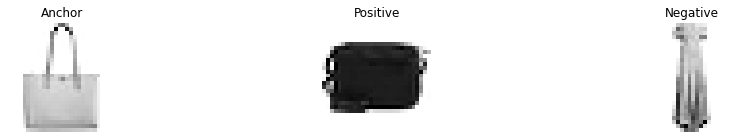

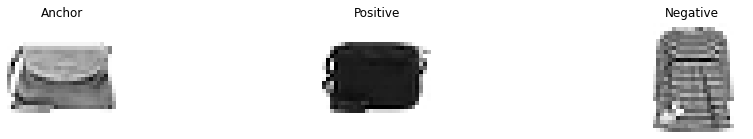

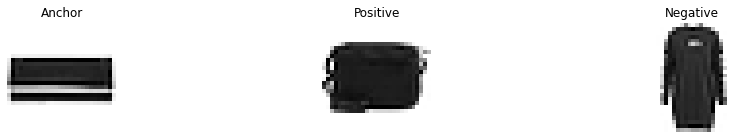

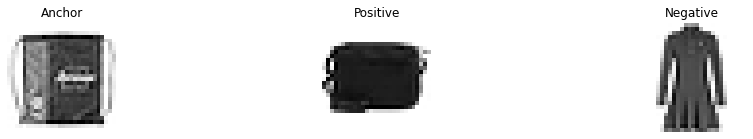

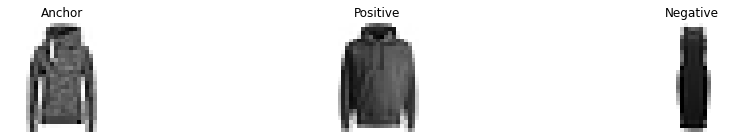

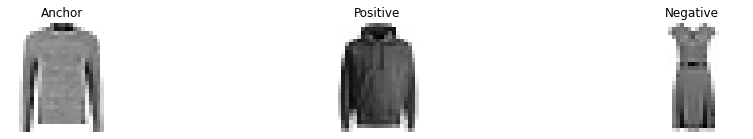

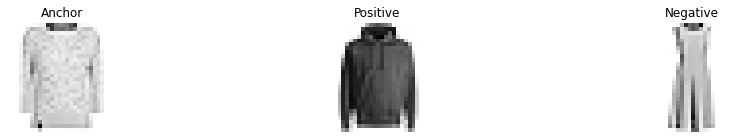

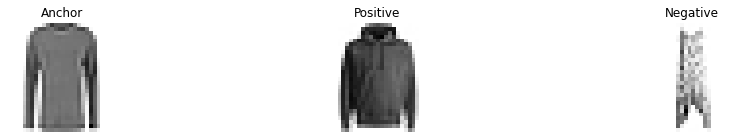

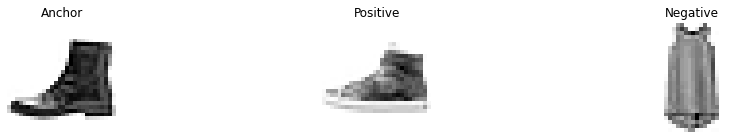

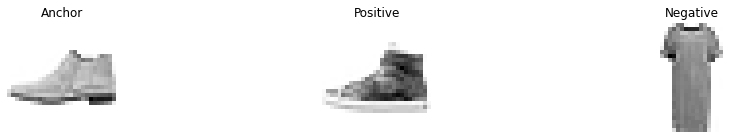

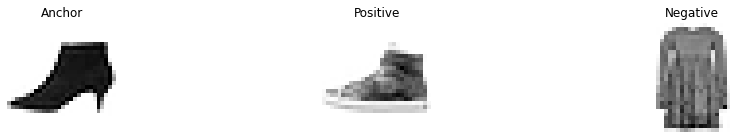

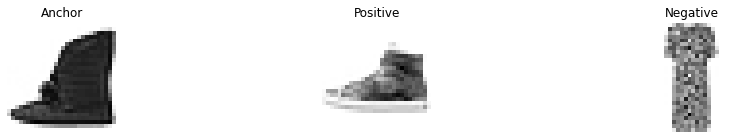

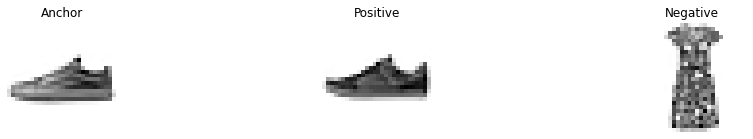

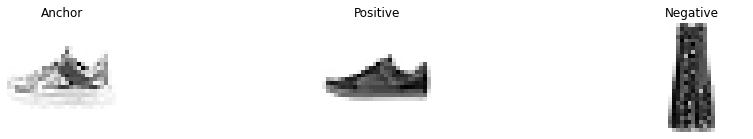

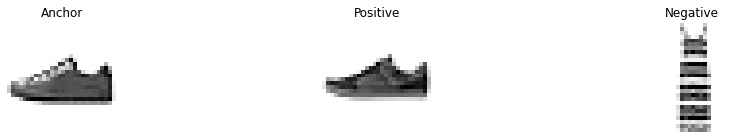

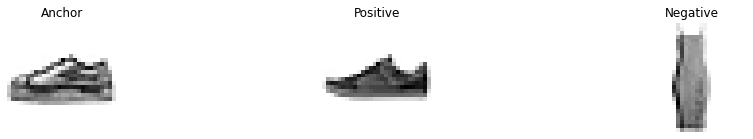

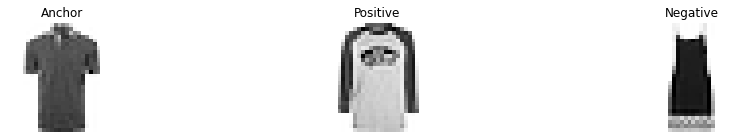

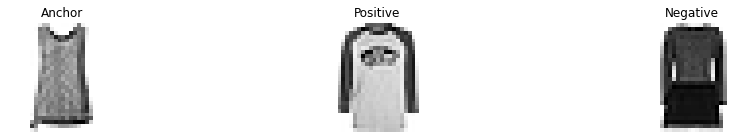

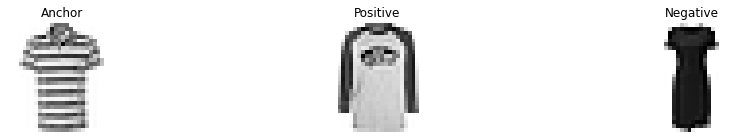

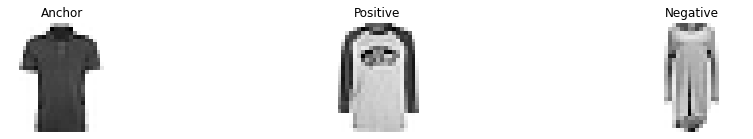

In [0]:
triplets = get_batch_moderate(12,model)
drawTriplets(triplets)

In [0]:
CMC = cumulative_matching_curve(x_test_origin,y_test_origin,model,1)

(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
0.124


In [0]:
inter_dist = compute_interdist(model)
print(inter_dist)


[[  0.         120.01339722 398.2928772  ... 598.70098877 371.48931885
  737.97625732]
 [120.01339722   0.         144.54165649 ... 478.15609741 246.51008606
  571.08312988]
 [398.2928772  144.54165649   0.         ... 483.98950195 330.13873291
  519.56286621]
 ...
 [598.70098877 478.15609741 483.98950195 ...   0.          59.39736176
   17.40637779]
 [371.48931885 246.51008606 330.13873291 ...  59.39736176   0.
  113.35768127]
 [737.97625732 571.08312988 519.56286621 ...  17.40637779 113.35768127
    0.        ]]


Debuggage

In [0]:


import time


tf.keras.backend.clear_session()
model = build_network(input_shape,64)
model_trained = 0
model_trained = build_model_moderate(input_shape, model)

model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
n_val = 1000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:236: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



 ------------- 

loss = 0.18179337680339813


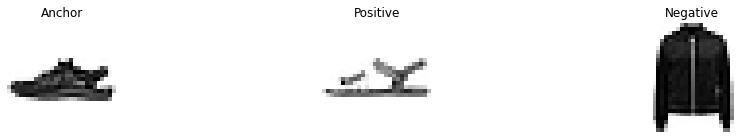

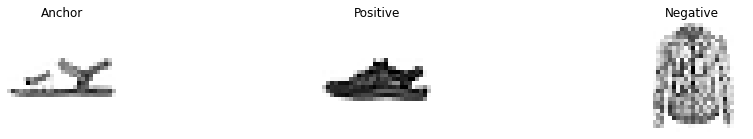

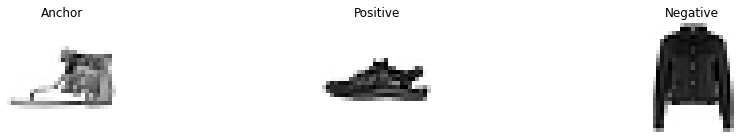

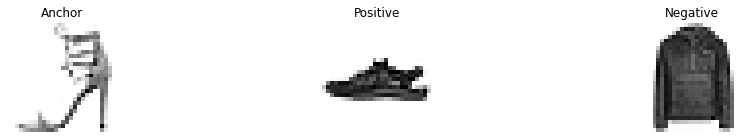

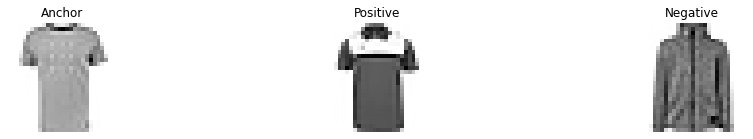

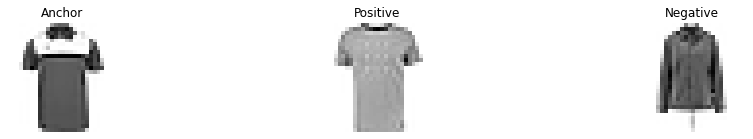

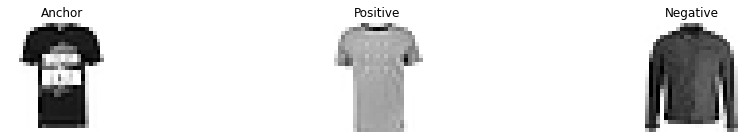

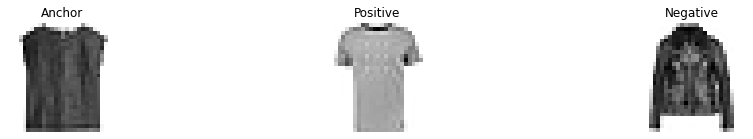

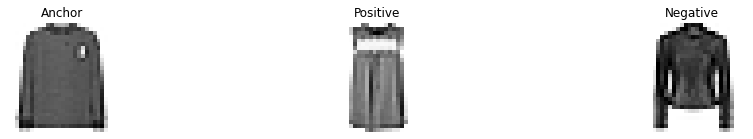

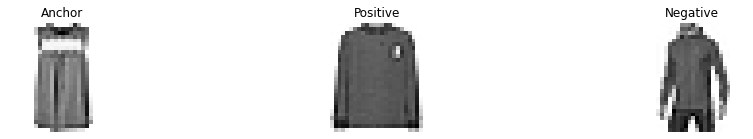

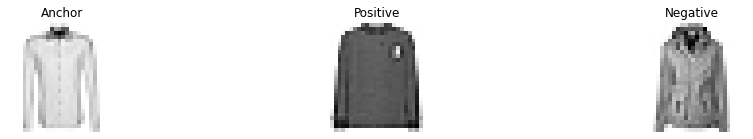

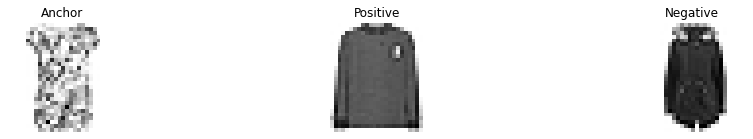

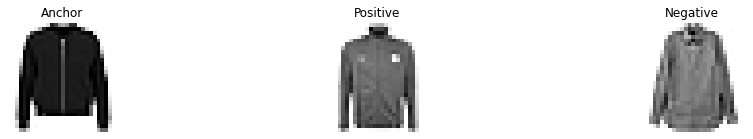

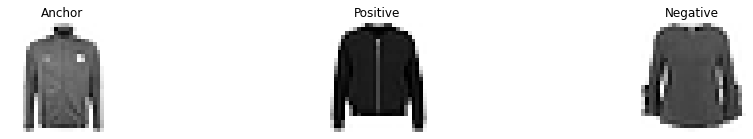

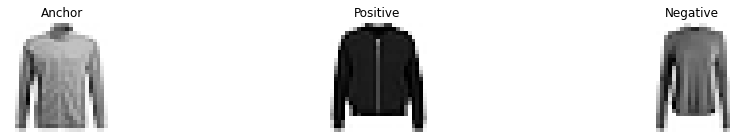

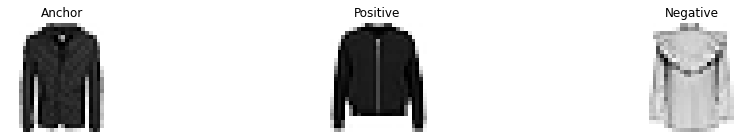

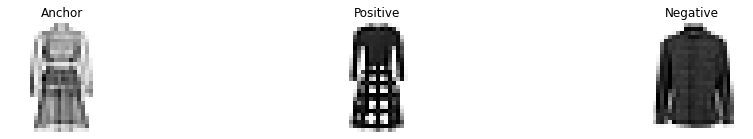

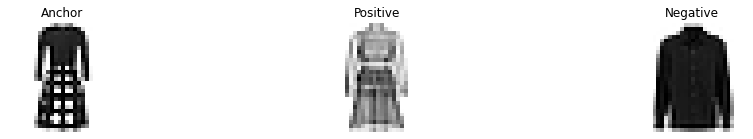

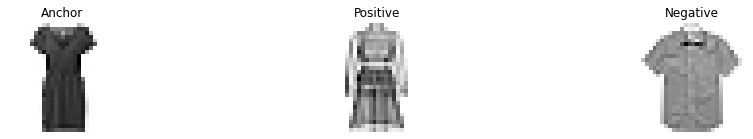

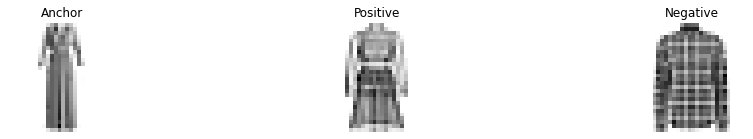

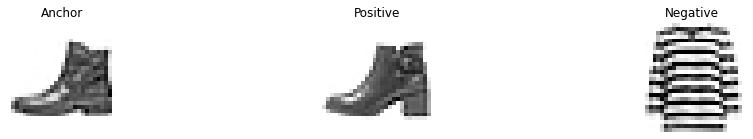

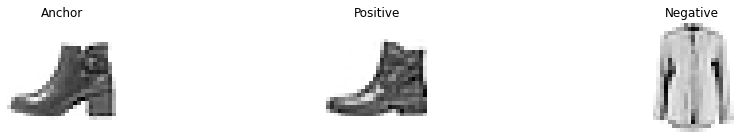

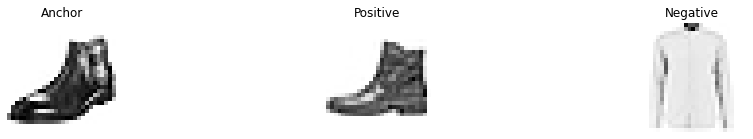

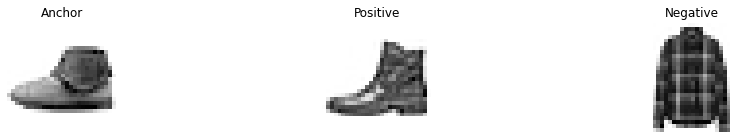

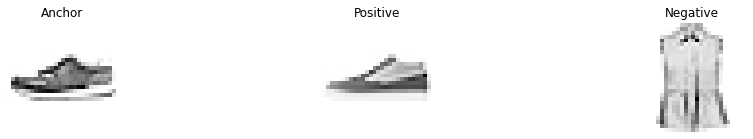

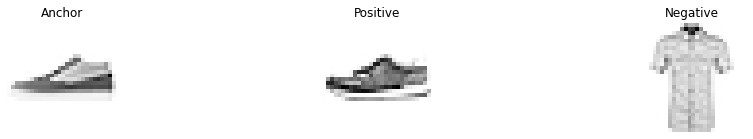

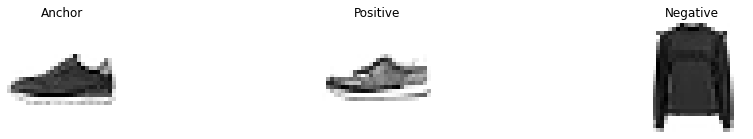

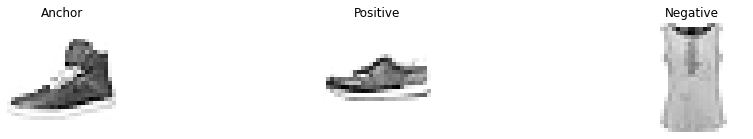

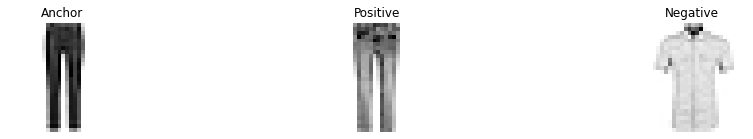

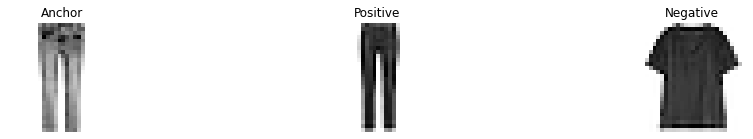

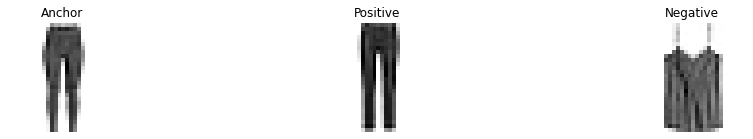

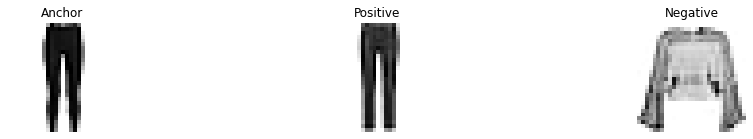

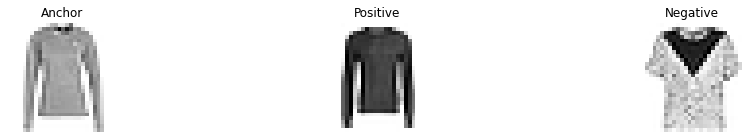

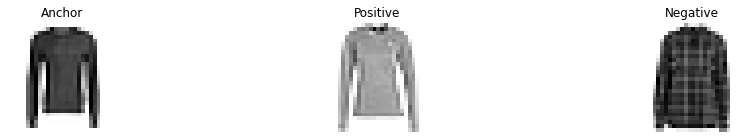

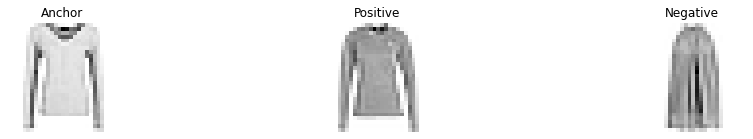

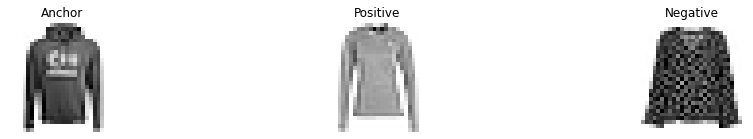

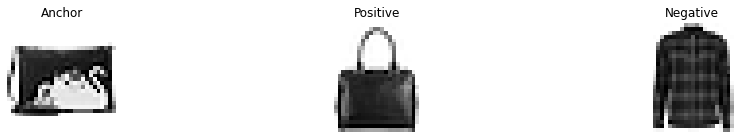

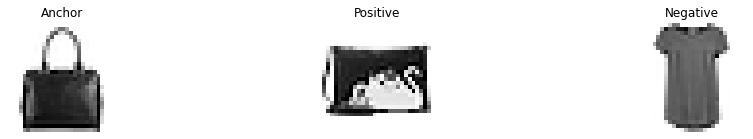

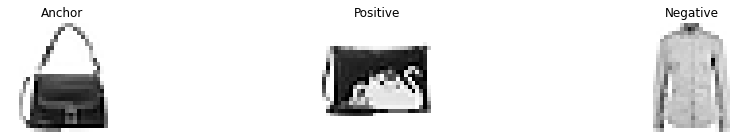

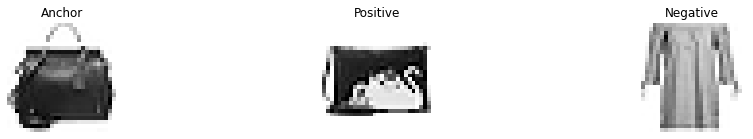

In [0]:
triplets = get_batch_moderate(14,model)
drawTriplets(tripletbatch=triplets)
#print(triplets.shape)
loss = model_trained.train_on_batch(triplets, None)

print("\n ------------- \n")
print("loss = " + str(loss))
probs,yprob = compute_probs(model,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])


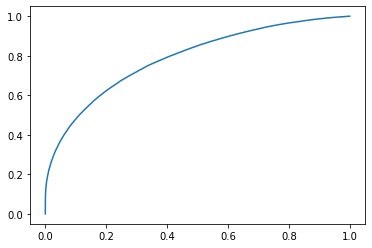

In [0]:
#compute_interdist(model)
probs,yprob = compute_probs(model,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)

plt.figure()
plt.plot(fpr,tpr)

#plt.plot(thresholds)
